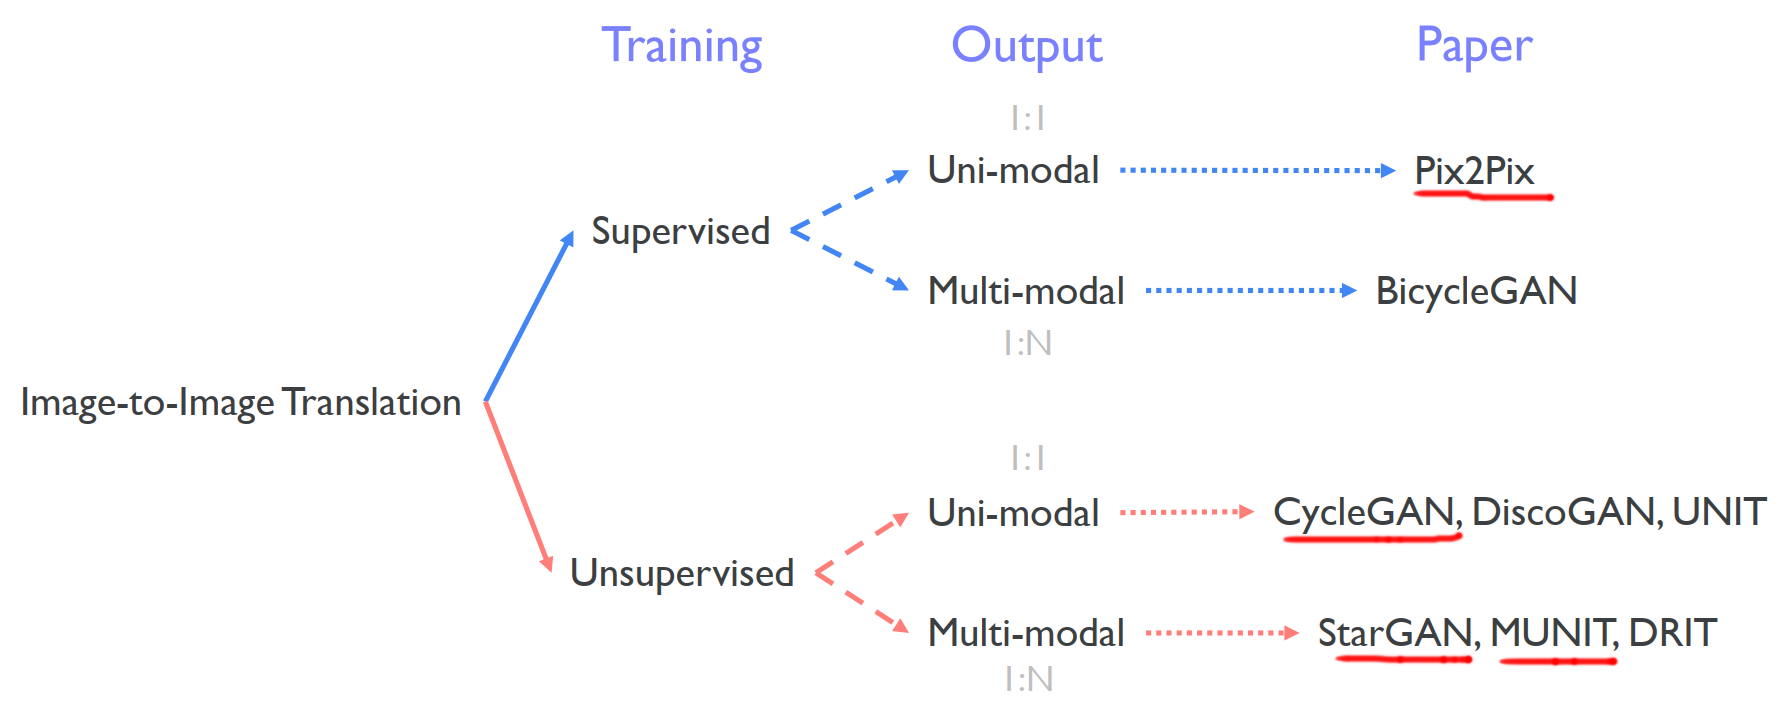

# Pix2Pix model
* Pix2Pix là 1 mạng GAN nên cũng có 2 phần Generator (G) và Discriminator (D) để phân biệt ảnh thật và ảnh fake.
* Tuy nhiên khác với những mạng GAN bình thường khi input của Generator là noise, thì trong Pix2Pix input của Generator là ảnh vẽ, và output của Generator là ảnh đủ màu sắc
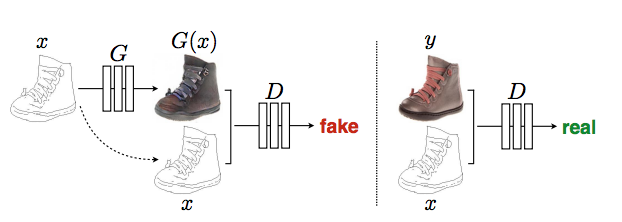

# 1. Generator
* Input là ảnh vẽ và output là ảnh màu (có thể tượng tượng đến U-Net khi segment ra các foreground rồi tô màu lên)
* Mô hình có dạng encoder-decoder, các đường màu đỏ sử dụng ý tưởng của resnet (densenet) để nối các layer tương ứng ở encoder vs decoder
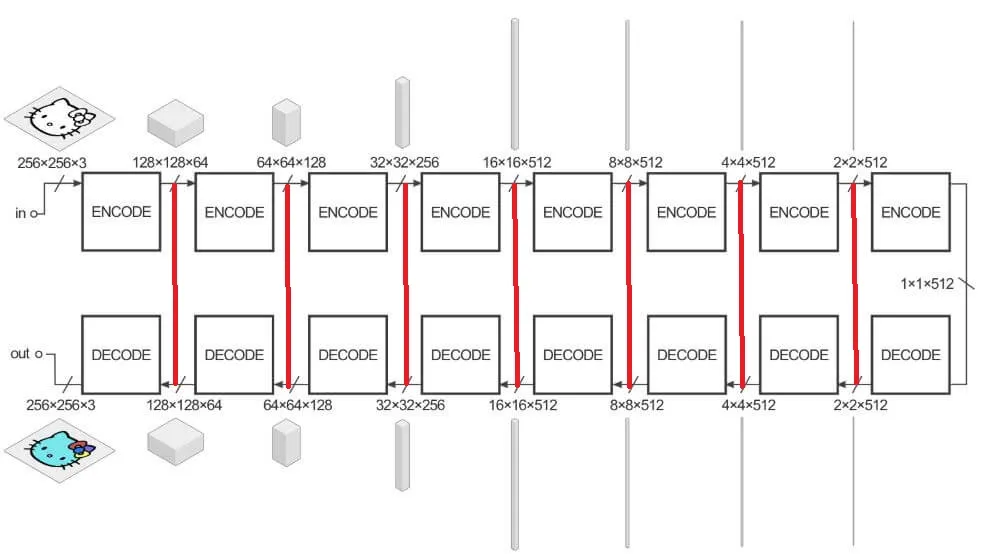

# 2. Discriminator
* Có 2 trường hợp input và output (nhưng đều có 2 ảnh):
    1. Input của generator và ảnh output của generator
    2. Input của generator và ảnh output thật
* Điểm khác ở đây là input của Discriminator còn có cả ảnh input đầu vào nữa:
    * Vì mạng GAN thông thường input là noise, còn Pix2Pix input là ảnh vẽ nên còn được gọi là condition GAN (cGAN), tức là ảnh output ra phụ thuộc vào ảnh input đầu vào
    * Việc cho cả ảnh input vào giúp Discriminator dễ phân biệt hơn ảnh nào là Generator sinh ra và ảnh nào trong dataset
    
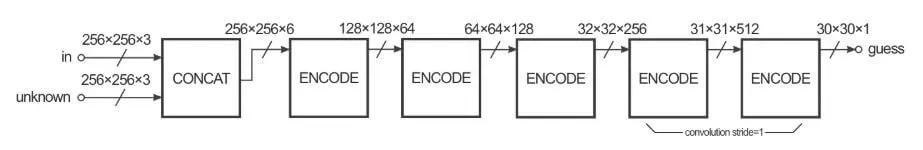
* 2 ảnh đầu vào sẽ được nối với nhau sau đó thực hiện các lớp trong ConvNet và ra output là ma trận 2 chiều

# 3. PatchGAN
* Ý tưởng GAN truyền thống sẽ là output 1 node và là bài toán binary classification
* Ý tưởng patchGAN sẽ thực hiện binary classification trên từng vùng ảnh nhỏ (70, 70) trên ảnh (224, 224) thay vì làm toàn bộ trên ảnh
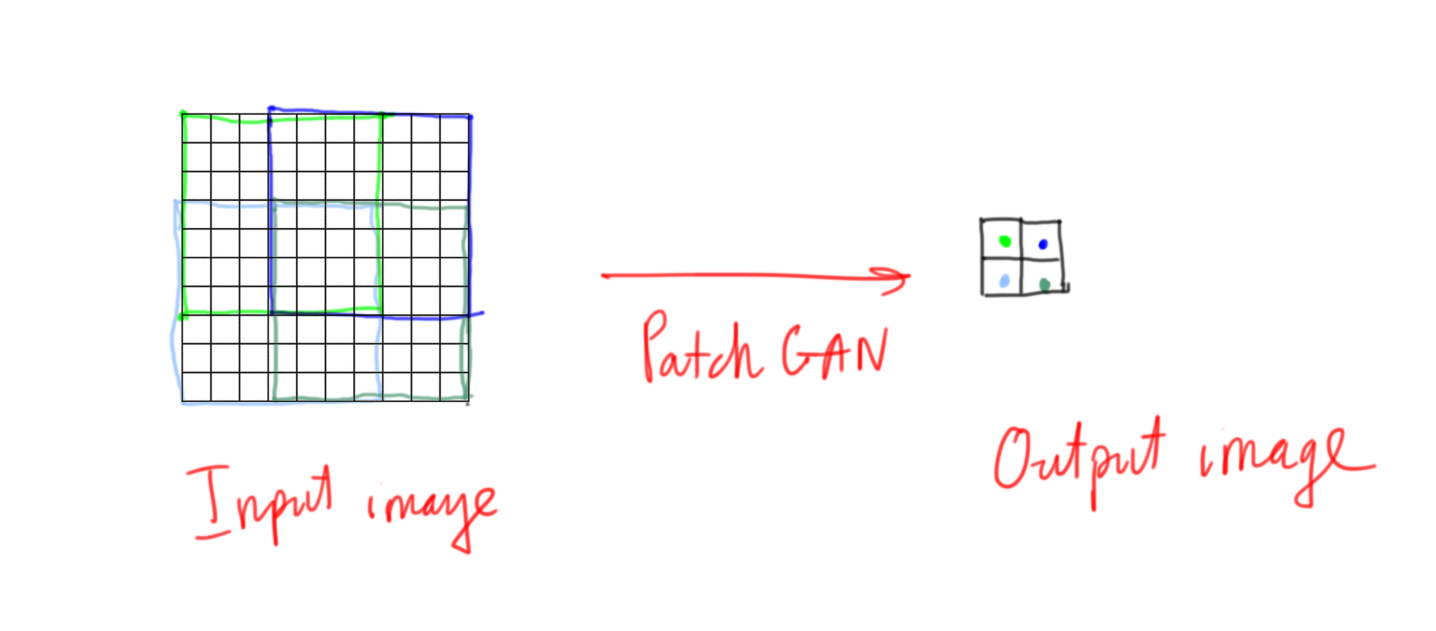
* PatchGAN discriminator hay hơn ở chỗ là nó sẽ phân loại từng patch nhỏ một hay thì cả ảnh nên sẽ tốt hơn:
    * Khi train Discriminator vs ảnh thật ta mong muốn output ra tất cả các patch là 1, còn với ảnh fake tất cả các patch là 0
    * Khi train Generator ta mong muốn với ảnh fake tất cả các patch là 1

# 4. Loss function
* Loss function của Pix2Pix giống với GAN bình thường (paper gốc tác giả sử dụng LSGAN)
* Bên cạnh đó tác giả còn sử dụng L1 giữa output của Generator và otuput thật trong dataset
* GAN loss học được các chi tiết khung ảnh nhiều hơn còn L1 sẽ học được các chi tiết nhỏ (style) của ảnh
> $\Rightarrow$ 2 loss kết hợp với nhau sẽ cho ra kết quả tốt hơn

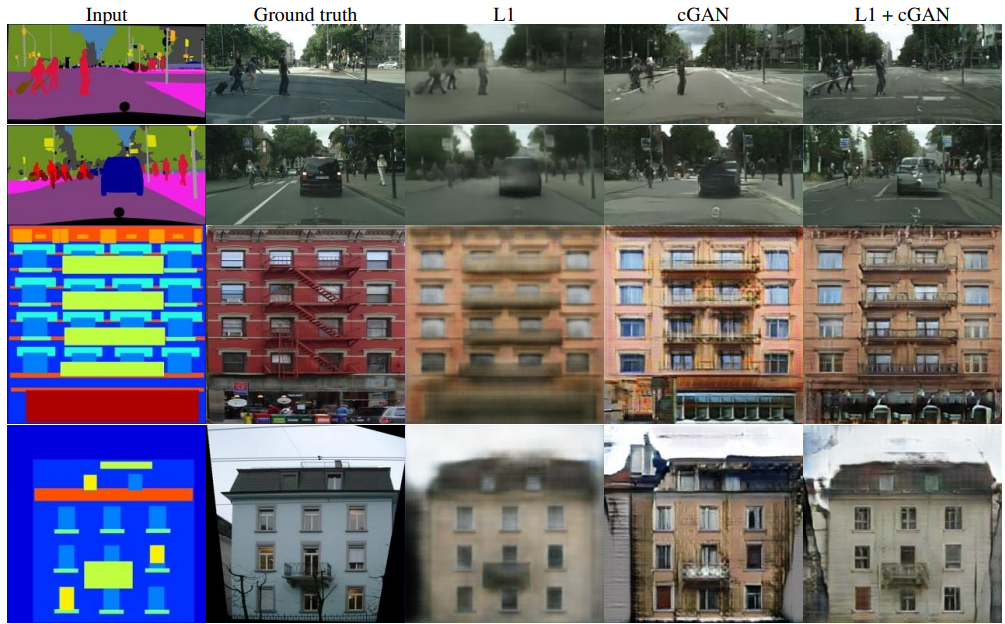

In [64]:
! pip install pydot
! pip install graphviz

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os, random, math
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm

In [28]:
! dir Pix2Pix_dataset\\

 Volume in drive E is HDD Repository 2
 Volume Serial Number is 381C-0CA3

 Directory of E:\LapTrinh\PYTHON\AI\Generative Adversarial Networks (GAN)\Pix2Pix_dataset

10/09/2021  08:48 PM    <DIR>          .
10/09/2021  08:48 PM    <DIR>          ..
10/09/2021  08:22 PM    <DIR>          cityscapes
10/09/2021  08:22 PM    <DIR>          edges2handbags
10/09/2021  08:22 PM    <DIR>          edges2shoes
10/09/2021  08:22 PM    <DIR>          facades
10/09/2021  08:22 PM    <DIR>          maps
10/09/2021  05:22 PM    <DIR>          Models
10/09/2021  08:22 PM    <DIR>          night2day
               0 File(s)              0 bytes
               9 Dir(s)  138,964,230,144 bytes free


In [54]:
def load_images(path, size = (256, 512)):
    src_arr, tag_arr = [], []
    
    for filename in os.listdir(path):
        pixels = load_img(path + filename, target_size = size)
        pixels = img_to_array(pixels)
        
        # Split into satellite and map
        sat_img, map_img = pixels[:, :256, :], pixels[:, 256:, :]
        src_arr.append(sat_img)
        tag_arr.append(map_img)
    src_arr = np.asarray(src_arr)
    tag_arr = np.asarray(tag_arr)
    return [src_arr, tag_arr]

path = 'Pix2Pix_dataset\\maps\\maps\\train\\'
src_arr, tag_arr = load_images(path)
print(src_arr.shape)
print(tag_arr.shape)

# Save as compressed numpy array
filename = 'maps_256.npz'
np.savez_compressed(filename, src_arr, tag_arr)

(1096, 256, 256, 3)
(1096, 256, 256, 3)


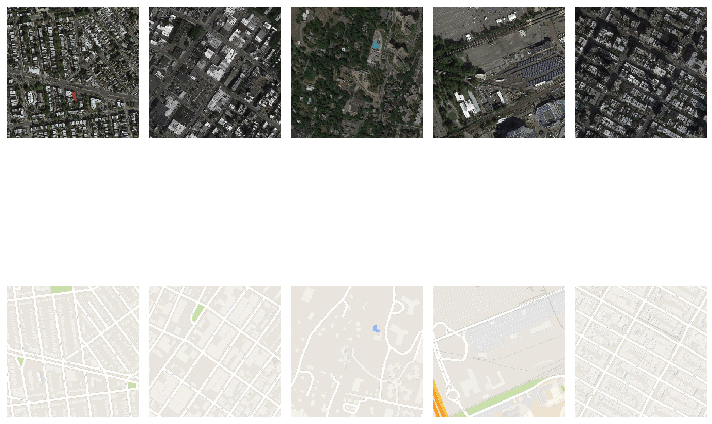

In [60]:
data = np.load('maps_256.npz')
src_imgs, tag_imgs = data['arr_0'], data['arr_1']

def plot_images(src_imgs, tag_imgs, n_samples):
    src_imgs = src_imgs.astype('uint8')
    tag_imgs = tag_imgs.astype('uint8')
    
    rows = 2
    fig, axes = plt.subplots(rows, n_samples, figsize = (10, 10))
    
    for i in range(n_samples):
        axes[0, i].imshow(src_imgs[i], interpolation = 'nearest')
        axes[0, i].axis('off')
    for i in range(n_samples):
        axes[1, i].imshow(tag_imgs[i], interpolation = 'nearest')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

plot_images(src_arr, tag_arr, 5)

In [7]:
def build_discriminator(img_shape = (256, 256, 3)):
    init = RandomNormal(stddev = 0.02)
    
    # Source image input
    in_src_img = Input(shape = img_shape, name = 'source image input')
    # Target image input
    in_tag_img = Input(shape = img_shape, name = 'target image input')
    # Concatenate
    merge = Concatenate()([in_src_img, in_tag_img])
    # C64
    d = Conv2D(64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(merge)
    d = LeakyReLU(alpha = 0.2)(d)
    # C128
    d = Conv2D(128, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    # C256
    d = Conv2D(256, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    # C512
    d = Conv2D(512, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    # Second last output
    d = Conv2D(512, kernel_size = (4, 4), padding = 'same', kernel_initializer = init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    # Patch output
    d = Conv2D(1, kernel_size = (4, 4), padding = 'same', kernel_initializer = init, name = 'output')(d)
    patch_out = Activation('sigmoid')(d)
    
    # Define model
    model = Model(inputs = [in_src_img, in_tag_img], outputs = patch_out)
    adam = Adam(learning_rate = 2e-4, beta_1 = 0.5)
    model.compile(optimizer = adam, loss = 'binary_crossentropy', loss_weights = [0.5])
    return model

In [8]:
model = build_discriminator(img_shape = (256, 256, 3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
source image input (InputLayer) [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target image input (InputLayer) [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           source image input[0][0]         
                                                                 target image input[0][0]         
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]          

In [9]:
def build_encoder_block(layer_in, n_filters, batchNorm = True):
    init = RandomNormal(stddev = 0.02)
    
    # Add downsampling layer
    g = Conv2D(n_filters, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(layer_in)
    
    if batchNorm:
        g = BatchNormalization()(g, training = True) 
    g = LeakyReLU(alpha = 0.2)(g)
    return g

def build_decoder_block(layer_in, skip_in, n_filters, dropOut = True):
    init = RandomNormal(stddev = 0.02)
    
    # Add upsampling layer
    g = Conv2DTranspose(n_filters, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(layer_in)
    g = BatchNormalization()(g, training = True)
    
    if dropOut:
        g = Dropout(0.5)(g, training = True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

def build_generator(img_shape = (256, 256, 3)):
    init = RandomNormal(stddev = 0.02)
    
    # Image input
    in_img = Input(shape = img_shape)
    # Encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = build_encoder_block(in_img, 64, batchNorm = False)
    e2 = build_encoder_block(e1, 128)
    e3 = build_encoder_block(e2, 256)
    e4 = build_encoder_block(e3, 512)
    e5 = build_encoder_block(e4, 512)
    e6 = build_encoder_block(e5, 512)
    e7 = build_encoder_block(e6, 512)
    
    # Bottelneck, no BatchNorm and apply ReLU instead of LeakyReLU
    b = Conv2D(512, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(e7)
    b = Activation('relu')(b)
    
    # Decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = build_decoder_block(b, e7, 512)
    d2 = build_decoder_block(d1, e6, 512)
    d3 = build_decoder_block(d2, e5, 512)
    d4 = build_decoder_block(d3, e4, 512, dropOut = False)
    d5 = build_decoder_block(d4, e3, 256, dropOut = False)
    d6 = build_decoder_block(d5, e2, 128, dropOut = False)
    d7 = build_decoder_block(d6, e1, 64, dropOut = False)
    
    # Output
    g = Conv2DTranspose(3, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(d7)
    out_img = Activation('tanh')(g)
    
    model = Model(inputs = in_img, outputs = out_img)
    return model

In [11]:
model = build_generator(img_shape = (256, 256, 3))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_17 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 128)  131200      leaky_re_lu_17[0][0]             
____________________________________________________________________________________________

In [12]:
def build_gan(g_model, d_model, img_shape = (256, 256, 3)):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # Source image
    in_src = Input(shape = img_shape)
    g_out = g_model(in_src)
    d_out = d_model([in_src, g_out])
    
    model = Model(inputs = in_src, outputs = [d_out, g_out])
    
    adam = Adam(learning_rate = 2e-4, beta_1 = 0.5)
    model.compile(optimizer = adam, loss = ['binary_crossentropy', 'mae'], loss_weights = [1.100])
    return model

In [13]:
img_shape = (256, 256, 3)
d_model = build_discriminator(img_shape)
g_model = build_generator(img_shape)

gan_model = build_gan(g_model, d_model, img_shape)
gan_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Functional)            (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model_4 (Functional)            (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 model_5[0][0]                    
Total params: 61,397,572
Trainable params: 54,422,275
Non-trainable params: 6,975,297
__________________________________________________________________________________________________


In [61]:
def load_real_samples(filename):
    data = np.load(data)
    src_imgs, tag_imgs = data['arr_0'] / 255, data['arr_1'] / 255
    X1 = (src_imgs * 2) - 1
    X2 = (tag_imgs * 2) - 1
    return [X1, X2]

In [15]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = np.random.randint(0, trainA.shape[0], size = n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [62]:
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [63]:
def summarize_performance(g_model, dataset, step, n_samples = 5):
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    
    rows = 3
    fig, axes = plt.subplots(rows, n_samples, figsize = (10, 10))
    
    for i in range(n_samples):
        axes[0, i].imshow(X_realA[i], interpolation = 'nearest')
        axes[0, i].axis('off')
    for i in range(n_samples):
        axes[1, i].imshow(X_fakeB[i], interpolation = 'nearest')
        axes[1, i].axis('off')
    for i in range(n_samples):
        axes[2, i].imshow(X_realB[i], interpolation = 'nearest')
        axes[2, i].axis('off')
    plt.tight_layout()
    plt.show()
    
    filename1 = './Images/plot_%06d.png' % (step + 1)
    fig.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = './Models/model_%06d.h5' % (step + 1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [18]:
def train(g_model, d_model, gan_model, dataset, n_epochs = 100, batch_size = 1, plot_frequency = 5):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    batch_per_epoch = trainA.shape[0] // batch_size
    n_steps = batch_per_epoch * n_epochs
    
    for e in tqdm(range(1, n_steps + 1), desc = 'progress bar'):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, batch_size, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        if e % (plot_frequency * batch_per_epoch) == 0:
            print('*' * 15 + 'Epoch %d' % (e // batch_per_epoch) + '*' * 15)
            summarize_performance(g_model, dataset, e)

In [ ]:
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

img_shape = dataset[0].shape[1:]

d_model = build_discriminator(img_shape)
g_model = build_generator(img_shape)

gan_model = build_gan(g_model, d_model, img_shape)

train(g_model, d_model, gan_model, dataset, plot_frequency = 5, n_epochs = 100)